# Property Click Prediction

## Table of Contents

- [Objective](#objective)
- [Read and Explore Data](#read-explore-data)
- [Data Engineering](#data-engineering)
    - [Process Photos Data](#process-photos-data)
    - [Number of Interactions within 3 Days](#interactions-three-days)
    - [Number of Interactions within 7 Days](#interactions-seven-days)
    - [Merge Data](#merge-data)
- [Exploratory Data Analysis and Processing](#eda-processing)
- [Feature Engineering](#feature-engineering)
    - [Remove Outliers](#remove-outliers)
    - [One Hot Encoding](#one-hot-encoding)
    - [MinMax Scaler](#minmax-scaler)
- [Machine Learning](#machine-learning)
    - [Predicting Interactions within 3 Days](#predict-three-days)
    - [Predicting Interactions within 7 Days](#predict-seven-days)
- [Deep Learning](#deep-learning)

## Objective <a id='objective'></a>

The task is to build a predictive model to estimate the number of interactions that a property would receive in a specified period of time. Here, the time intervals will be within **3** and **7** days of activation.

## Read and Explore Data <a id='read-explore-data'></a>

In [1]:
# Import libraries and modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Machine learning
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor

# Deep learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, PReLU, ELU, Dropout

In [2]:
# Set options for pandas
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 10)

In [3]:
# Read all data

# Read property data
data = pd.read_csv('data/raw/property_data_set.csv', parse_dates=['activation_date'], dayfirst=True)

# Read property interactions data
interactions = pd.read_csv('data/raw/property_interactions.csv', parse_dates=['request_date'], dayfirst=True)

# Read property photos data
photos = pd.read_table('data/raw/property_photos.tsv')

In [4]:
# Print shape of all data
print(f'Property data shape: {data.shape}')
print(f'Property interactions data shape: {interactions.shape}')
print(f'Property photos data shape: {photos.shape}')

Property data shape: (28888, 21)
Property interactions data shape: (170611, 2)
Property photos data shape: (28888, 2)


In [5]:
# Sample of property data
data.sample(n=5)

,property_id,type,activation_date,bathroom,floor,total_floor,furnishing,gym,latitude,longitude,lease_type,lift,locality,parking,property_age,property_size,swimming_pool,pin_code,rent,deposit,building_type
5092,ff8081815606d2640156081368ac3f98,BHK2,2017-03-12 15:47:00,2,3,4.0,SEMI_FURNISHED,0,12.849208,77.590872,FAMILY,1,Gottigere,BOTH,0,933,0,560076.0,12500,125000,AP
8644,ff808181599713b20159a1e11db021ee,BHK1,2017-03-24 15:18:00,1,11,12.0,SEMI_FURNISHED,1,12.839939,77.677003,ANYONE,1,"Electronic City, Bengaluru, Karnataka, India",BOTH,0,635,0,560099.0,12000,80000,AP
27947,ff8081815b0f1e48015b0f2fcfef07e6,BHK2,2017-03-27 15:53:00,2,1,4.0,SEMI_FURNISHED,0,13.006643,77.650382,ANYONE,1,Banswadi,BOTH,0,900,0,560043.0,6666,50000,AP
27251,ff8081815b04b57a015b050d00bc2c43,BHK1,2017-03-25 16:44:00,1,2,3.0,SEMI_FURNISHED,0,13.048495,77.601586,FAMILY,0,Hebbal Kempapura,TWO_WHEELER,0,350,0,560024.0,7500,75000,IF
10614,ff8081815a0d0db9015a0d63a61a13e0,BHK2,2017-02-05 15:08:00,2,0,1.0,SEMI_FURNISHED,0,12.990135,77.676122,ANYONE,0,Udayanagar,BOTH,20,1200,0,560016.0,12000,100000,IF


In [6]:
# Sample of interactions data
interactions.sample(n=5)

,property_id,request_date
55678,ff808181596e34b001596e4eb61207d8,2017-03-22 22:51:20
60371,ff80818159d0c6ed0159d50c01db41c6,2017-03-23 09:00:49
126969,ff8081815a9dca24015a9e6dc18c6227,2017-03-30 20:37:37
11412,ff808181505cc00b01505cca8e79005a,2017-02-19 10:57:23
106605,ff8081815a6f4811015a6fdb8c2e3c46,2017-02-27 20:45:41


In [7]:
# Sample of photos data
photos.sample(n=5)

,property_id,photo_urls
26032,ff8081815af0f7fd015af11c36d410e7,"[{\title\"":\""\"",\""name\"":\""files[]\"",\""imagesM..."
16605,ff8081815a69bafb015a6a25b2373ee1,"[{\title\"":\""\"",\""name\"":\""files[]\"",\""imagesM..."
28590,ff8081815b15c304015b1a0a0a5e321a,"[{\title\"":\""\"",\""name\"":\""files[]\"",\""imagesM..."
11772,ff8081815a1817c2015a1d7ac34f400c,NaN
24746,ff8081815adc9d9c015adfe069de04ca,NaN


## Data Engineering <a id='data-engineering'></a>

### Process Photos Data <a id='process-photos-data'></a>

In [8]:
# Return first 5 rows
photos.head()

,property_id,photo_urls
0,ff808081469fd6e20146a5af948000ea,"[{\title\"":\""Balcony\"",\""name\"":\""IMG_20131006..."
1,ff8080814702d3d10147068359d200cd,NaN
2,ff808081470c645401470fb03f5800a6,"[{\title\"":\""Bedroom\"",\""name\"":\""ff808081470c..."
3,ff808081470c6454014715eaa5960281,"[{\title\"":\""Bedroom\"",\""name\"":\""Screenshot_7..."
4,ff808081474aa867014771a0298f0aa6,"[{\title\"":\""Other\"",\""name\"":\""ff808081474aa8..."


In [9]:
# Check data types
photos.dtypes

property_id    object
photo_urls     object
dtype: object

In [10]:
# Check NaN values
photos.isna().sum()

property_id        0
photo_urls     11022
dtype: int64

In [11]:
# Correct the first JSON

# First JSON string
text_before = photos['photo_urls'][0]
print(f'Before correction:\n\n{text_before}')

# Replace corrupted values and try to convert to JSON
try:
    text_after = json.loads(text_before.replace('\\', '').replace('{title', '{"title').replace(']"', ']').replace('],"', ']","'))
    print(f'\nAfter correction and converted to JSON:\n\n{text_after}')
except json.JSONDecodeError as e:
    print(f'\nError decoding JSON: {e}')

Before correction:

[{\title\":\"Balcony\",\"name\":\"IMG_20131006_120837.jpg\",\"imagesMap\":{\"original\":\"ff808081469fd6e20146a5af948000ea_65149_original.jpg\",\"thumbnail\":\"ff808081469fd6e20146a5af948000ea_65149_thumbnail.jpg\",\"medium\":\"ff808081469fd6e20146a5af948000ea_65149_medium.jpg\",\"large\":\"ff808081469fd6e20146a5af948000ea_65149_large.jpg\"},\"displayPic\":false},{\"title\":\"Bathroom\",\"name\":\"IMG_20131006_120734.jpg\",\"imagesMap\":{\"original\":\"ff808081469fd6e20146a5af948000ea_63511_original.jpg\",\"thumbnail\":\"ff808081469fd6e20146a5af948000ea_63511_thumbnail.jpg\",\"medium\":\"ff808081469fd6e20146a5af948000ea_63511_medium.jpg\",\"large\":\"ff808081469fd6e20146a5af948000ea_63511_large.jpg\"},\"displayPic\":false},{\"title\":\"Bedroom\",\"name\":\"IMG_20131006_120643.jpg\",\"imagesMap\":{\"original\":\"ff808081469fd6e20146a5af948000ea_16708_original.jpg\",\"thumbnail\":\"ff808081469fd6e20146a5af948000ea_16708_thumbnail.jpg\",\"medium\":\"ff808081469fd6e2014

In [12]:
# lambda function to correct corrupted JSON and get count of photos
correction = lambda x: len(json.loads(str(x).replace('\\', '').replace('{title', '{"title').replace(']"', ']').replace('],"', ']","'))) if pd.notna(x) else 0

# Apply correction function
photos['photo_count'] = photos['photo_urls'].apply(correction)

In [13]:
# Drop `photo_urls` column
del photos['photo_urls']

# Sample of photos data
photos.sample(n=5)

,property_id,photo_count
26459,ff8081815af67c48015af99036cb5e0a,15
17127,ff8081815a701e88015a7392317319f9,0
22477,ff8081815ab805ff015abd200e216338,0
5882,ff8081815733b1560157366107640e82,5
13592,ff8081815a3ba7d2015a3bb61d9a0b36,0


### Number of Interactions within 3 Days <a id='interactions-three-days'></a>

In [14]:
# Merge property and interactions data
num_req = pd.merge(left=data, right=interactions, how='left', on='property_id')[['property_id', 'request_date', 'activation_date']]
num_req.head()

,property_id,request_date,activation_date
0,ff808081469fd6e20146a5af948000ea,2017-03-10 17:42:34,2017-03-09 14:36:00
1,ff808081469fd6e20146a5af948000ea,2017-03-09 15:51:17,2017-03-09 14:36:00
2,ff808081469fd6e20146a5af948000ea,2017-03-10 17:30:22,2017-03-09 14:36:00
3,ff808081469fd6e20146a5af948000ea,2017-03-11 17:48:46,2017-03-09 14:36:00
4,ff8080814702d3d10147068359d200cd,2017-03-30 19:59:15,2017-03-07 12:02:00


In [15]:
# Create column for time between request and activation dates, in days
num_req['request_time_days'] = (pd.to_datetime(num_req['request_date']) - pd.to_datetime(num_req['activation_date'])) / np.timedelta64(1, 'D')
num_req.head()

,property_id,request_date,activation_date,request_time_days
0,ff808081469fd6e20146a5af948000ea,2017-03-10 17:42:34,2017-03-09 14:36:00,1.129560
1,ff808081469fd6e20146a5af948000ea,2017-03-09 15:51:17,2017-03-09 14:36:00,0.052280
2,ff808081469fd6e20146a5af948000ea,2017-03-10 17:30:22,2017-03-09 14:36:00,1.121088
3,ff808081469fd6e20146a5af948000ea,2017-03-11 17:48:46,2017-03-09 14:36:00,2.133866
4,ff8080814702d3d10147068359d200cd,2017-03-30 19:59:15,2017-03-07 12:02:00,23.331424


In [16]:
# Get count of requests within first three days
num_req_within_3days = num_req[num_req['request_time_days'] < 3].groupby(by='property_id', as_index=False).agg(n_requests_within_3days=('request_time_days', 'count'))
num_req_within_3days

,property_id,n_requests_within_3days
0,ff808081469fd6e20146a5af948000ea,4
1,ff8080814702d3d10147068359d200cd,3
2,ff808081470c645401470fb03f5800a6,15
3,ff808081470c6454014715eaa5960281,5
4,ff808081474aa867014771a0298f0aa6,25
...,...,...
13205,ff8081815b1fdda8015b1fdf585c004b,2
13206,ff8081815b1fdda8015b1fe675ae0146,5
13207,ff8081815b1fdda8015b1ffee8a305d2,2
13208,ff8081815b200540015b20158b0103c9,2


In [17]:
# Get frequency of distinct rows
num_req_within_3days['n_requests_within_3days'].value_counts()[:10]

n_requests_within_3days
1     5940
2     2741
3     1579
4      887
5      583
6      373
7      246
8      186
9      148
11     105
Name: count, dtype: int64

In [18]:
# Create column for categories
num_req_within_3days['categories_3days'] = pd.cut(x=num_req_within_3days['n_requests_within_3days'], bins=[-np.inf, 2, 5, np.inf], labels=['cat_1_to_2', 'cat_3_to_5', 'cat_above_5'])
num_req_within_3days.head(n=10)

,property_id,n_requests_within_3days,categories_3days
0,ff808081469fd6e20146a5af948000ea,4,cat_3_to_5
1,ff8080814702d3d10147068359d200cd,3,cat_3_to_5
2,ff808081470c645401470fb03f5800a6,15,cat_above_5
3,ff808081470c6454014715eaa5960281,5,cat_3_to_5
4,ff808081474aa867014771a0298f0aa6,25,cat_above_5
5,ff8080814780f308014797c79000082e,2,cat_1_to_2
6,ff80808147a95f0a0147ab0d88fa0080,3,cat_3_to_5
7,ff80808147ac6af10147afc279480099,1,cat_1_to_2
8,ff80808147cbdc2a0147cf8577880153,5,cat_3_to_5
9,ff80808147ed5e680147f326ca4c02d2,7,cat_above_5


In [19]:
# Get frequencies for categories
num_req_within_3days['categories_3days'].value_counts()

categories_3days
cat_1_to_2     8681
cat_3_to_5     3049
cat_above_5    1480
Name: count, dtype: int64

### Number of Interactions within 7 Days <a id='interactions-seven-days'></a>

In [20]:
# Get count of requests within first seven days
num_req_within_7days = num_req[num_req['request_time_days'] < 7].groupby(by='property_id', as_index=False).agg(n_requests_within_7days=('request_time_days', 'count'))
num_req_within_7days

,property_id,n_requests_within_7days
0,ff808081469fd6e20146a5af948000ea,4
1,ff8080814702d3d10147068359d200cd,5
2,ff808081470c645401470fb03f5800a6,22
3,ff808081470c6454014715eaa5960281,7
4,ff808081474aa867014771a0298f0aa6,52
...,...,...
17381,ff8081815b1fdda8015b1fe675ae0146,8
17382,ff8081815b1fdda8015b1ffee8a305d2,3
17383,ff8081815b1fdda8015b2000369205fd,2
17384,ff8081815b200540015b20158b0103c9,2


In [21]:
# Get frequency of distinct rows
num_req_within_7days['n_requests_within_7days'].value_counts()[:10]

n_requests_within_7days
1     5856
2     3381
3     2118
4     1421
5     1047
6      735
7      597
8      373
9      323
10     240
Name: count, dtype: int64

In [22]:
# Create column for categories
num_req_within_7days['categories_7days'] = pd.cut(x=num_req_within_7days['n_requests_within_7days'], bins=[-np.inf, 2, 5, np.inf], labels=['cat_1_to_2', 'cat_3_to_5', 'cat_above_5'])
num_req_within_7days.head(n=10)

,property_id,n_requests_within_7days,categories_7days
0,ff808081469fd6e20146a5af948000ea,4,cat_3_to_5
1,ff8080814702d3d10147068359d200cd,5,cat_3_to_5
2,ff808081470c645401470fb03f5800a6,22,cat_above_5
3,ff808081470c6454014715eaa5960281,7,cat_above_5
4,ff808081474aa867014771a0298f0aa6,52,cat_above_5
5,ff8080814780f30801478d14132f03f4,1,cat_1_to_2
6,ff8080814780f308014797c79000082e,3,cat_3_to_5
7,ff80808147a95f0a0147ab0d88fa0080,4,cat_3_to_5
8,ff80808147ac6af10147afc279480099,1,cat_1_to_2
9,ff80808147cbdc2a0147cf8577880153,12,cat_above_5


In [23]:
# Get frequencies for categories
num_req_within_7days['categories_7days'].value_counts()

categories_7days
cat_1_to_2     9237
cat_3_to_5     4586
cat_above_5    3563
Name: count, dtype: int64

### Merge Data <a id='merge-data'></a>

In [24]:
# Sample of property data
data.sample()

,property_id,type,activation_date,bathroom,floor,total_floor,furnishing,gym,latitude,longitude,lease_type,lift,locality,parking,property_age,property_size,swimming_pool,pin_code,rent,deposit,building_type
7118,ff8081815890ab9f01589659e4203c9e,RK1,2017-03-08 19:24:00,1,3,3.0,SEMI_FURNISHED,0,12.94819,77.703406,ANYONE,0,Munnekollal,BOTH,0,400,0,560037.0,7300,40000,IF


In [25]:
# Sample of property photos data
photos.sample()

,property_id,photo_count
9714,ff80818159fa0f0f0159fe4a25277184,7


In [26]:
# Sample of number of requests within 3 days
num_req_within_3days.sample()

,property_id,n_requests_within_3days,categories_3days
8807,ff8081815a902c06015a903cf385050a,4,cat_3_to_5


In [27]:
# Sample of number of requests within 7 days
num_req_within_7days.sample()

,property_id,n_requests_within_7days,categories_7days
9810,ff8081815a64ed4e015a652357752b36,6,cat_above_5


In [28]:
# Shape of number of requests data
print(num_req_within_3days.shape)
print(num_req_within_7days.shape)

(13210, 3)
(17386, 3)


In [29]:
# Merge number of requests within 3 and 7 days
label_data = pd.merge(left=num_req_within_7days, right=num_req_within_3days, how='left', on='property_id')
label_data.head()

,property_id,n_requests_within_7days,categories_7days,n_requests_within_3days,categories_3days
0,ff808081469fd6e20146a5af948000ea,4,cat_3_to_5,4.0,cat_3_to_5
1,ff8080814702d3d10147068359d200cd,5,cat_3_to_5,3.0,cat_3_to_5
2,ff808081470c645401470fb03f5800a6,22,cat_above_5,15.0,cat_above_5
3,ff808081470c6454014715eaa5960281,7,cat_above_5,5.0,cat_3_to_5
4,ff808081474aa867014771a0298f0aa6,52,cat_above_5,25.0,cat_above_5


In [30]:
# Check missing values
label_data.isna().sum()

property_id                   0
n_requests_within_7days       0
categories_7days              0
n_requests_within_3days    4176
categories_3days           4176
dtype: int64

In [31]:
# Merge property data with photos data
data_with_photos = pd.merge(left=data, right=photos, how='left', on='property_id')
data_with_photos.head()

,property_id,type,activation_date,bathroom,floor,total_floor,furnishing,gym,latitude,longitude,lease_type,lift,locality,parking,property_age,property_size,swimming_pool,pin_code,rent,deposit,building_type,photo_count
0,ff808081469fd6e20146a5af948000ea,BHK2,2017-03-09 14:36:00,1,3,4.0,SEMI_FURNISHED,1,12.876174,77.596571,FAMILY,1,Hulimavu,BOTH,2,850,1,560076.0,12000,120000,AP,7
1,ff8080814702d3d10147068359d200cd,BHK2,2017-03-07 12:02:00,2,4,11.0,SEMI_FURNISHED,1,13.018444,77.678122,FAMILY,1,Ramamurthy Nagar,BOTH,1,1233,1,560016.0,20000,150000,AP,0
2,ff808081470c645401470fb03f5800a6,BHK2,2017-03-10 13:43:00,2,0,4.0,NOT_FURNISHED,1,12.975072,77.665865,ANYONE,1,GM Palya,FOUR_WHEELER,0,1200,0,560075.0,15000,75000,AP,12
3,ff808081470c6454014715eaa5960281,BHK3,2017-03-09 22:16:00,2,3,4.0,SEMI_FURNISHED,0,12.888169,77.591282,ANYONE,0,Arakere,BOTH,1,1300,0,560076.0,17000,150000,AP,9
4,ff808081474aa867014771a0298f0aa6,BHK1,2017-03-15 18:29:00,1,1,2.0,SEMI_FURNISHED,0,12.990243,77.712962,ANYONE,0,Hoodi,BOTH,4,450,0,560048.0,6500,40000,IF,7


In [32]:
# Merge property and photos data with label data
df = pd.merge(data_with_photos, label_data, how='inner', on='property_id')
df.head()

,property_id,type,activation_date,bathroom,floor,total_floor,furnishing,gym,latitude,longitude,lease_type,lift,locality,parking,property_age,property_size,swimming_pool,pin_code,rent,deposit,building_type,photo_count,n_requests_within_7days,categories_7days,n_requests_within_3days,categories_3days
0,ff808081469fd6e20146a5af948000ea,BHK2,2017-03-09 14:36:00,1,3,4.0,SEMI_FURNISHED,1,12.876174,77.596571,FAMILY,1,Hulimavu,BOTH,2,850,1,560076.0,12000,120000,AP,7,4,cat_3_to_5,4.0,cat_3_to_5
1,ff8080814702d3d10147068359d200cd,BHK2,2017-03-07 12:02:00,2,4,11.0,SEMI_FURNISHED,1,13.018444,77.678122,FAMILY,1,Ramamurthy Nagar,BOTH,1,1233,1,560016.0,20000,150000,AP,0,5,cat_3_to_5,3.0,cat_3_to_5
2,ff808081470c645401470fb03f5800a6,BHK2,2017-03-10 13:43:00,2,0,4.0,NOT_FURNISHED,1,12.975072,77.665865,ANYONE,1,GM Palya,FOUR_WHEELER,0,1200,0,560075.0,15000,75000,AP,12,22,cat_above_5,15.0,cat_above_5
3,ff808081470c6454014715eaa5960281,BHK3,2017-03-09 22:16:00,2,3,4.0,SEMI_FURNISHED,0,12.888169,77.591282,ANYONE,0,Arakere,BOTH,1,1300,0,560076.0,17000,150000,AP,9,7,cat_above_5,5.0,cat_3_to_5
4,ff808081474aa867014771a0298f0aa6,BHK1,2017-03-15 18:29:00,1,1,2.0,SEMI_FURNISHED,0,12.990243,77.712962,ANYONE,0,Hoodi,BOTH,4,450,0,560048.0,6500,40000,IF,7,52,cat_above_5,25.0,cat_above_5


In [33]:
# Check missing values
df.isna().sum()

property_id                   0
type                          0
activation_date               0
bathroom                      0
floor                         0
                           ... 
photo_count                   0
n_requests_within_7days       0
categories_7days              0
n_requests_within_3days    4176
categories_3days           4176
Length: 26, dtype: int64

## Exploratory Data Analysis and Processing <a id='eda-processing'></a>

In [34]:
# Sample of data set
df.sample(n=5)

,property_id,type,activation_date,bathroom,floor,total_floor,furnishing,gym,latitude,longitude,lease_type,lift,locality,parking,property_age,property_size,swimming_pool,pin_code,rent,deposit,building_type,photo_count,n_requests_within_7days,categories_7days,n_requests_within_3days,categories_3days
6047,ff80818159fa0f0f0159fe1a9e9e4785,BHK2,2017-02-02 19:32:00,2,0,1.0,SEMI_FURNISHED,0,12.880838,77.569429,FAMILY,0,Konanakunte,TWO_WHEELER,6,1000,0,560062.0,13000,100000,IF,1,2,cat_1_to_2,1.0,cat_1_to_2
363,ff8081814d4b859b014d5298ee4028b1,BHK1,2017-02-20 14:45:00,2,4,4.0,SEMI_FURNISHED,0,12.952114,77.707715,ANYONE,0,Munnekollal,TWO_WHEELER,0,550,0,560037.0,11000,80000,IF,8,6,cat_above_5,4.0,cat_3_to_5
13244,ff8081815ab73b2b015ab7abf65c3ae9,BHK3,2017-03-10 16:21:00,2,1,2.0,SEMI_FURNISHED,0,12.908578,77.606611,BACHELOR,0,NS Palya,TWO_WHEELER,5,1200,0,560076.0,23000,100000,IF,0,1,cat_1_to_2,1.0,cat_1_to_2
9526,ff8081815a5c2573015a5c3d7db92128,BHK3,2017-03-21 16:42:00,2,0,2.0,SEMI_FURNISHED,0,12.916380,77.601155,ANYONE,0,BTM 2nd Stage,BOTH,20,1100,0,560076.0,25000,150000,AP,25,2,cat_1_to_2,1.0,cat_1_to_2
14823,ff8081815ad86bd8015adc18ac117265,BHK2,2017-03-17 18:03:00,2,1,1.0,SEMI_FURNISHED,0,12.929360,77.557211,FAMILY,0,Banashankari,BOTH,0,800,0,560085.0,15000,1,IF,0,4,cat_3_to_5,NaN,NaN


In [35]:
# Check frequencies of distinct rows in `locality` column
df['locality'].value_counts()

locality
Whitefield               517
JP Nagar                 415
Marathahalli             414
HSR Layout               380
Electronic City          341
                        ... 
Kereguddadahalli           1
Benson town                1
Block 1st Koramangala      1
Maruthi seva Nagar         1
Kammanahalli,Banswadi      1
Name: count, Length: 1714, dtype: int64

In [36]:
# Drop columns that will not affect number of requests
df = df.drop(columns=['property_id', 'activation_date', 'latitude', 'longitude', 'pin_code', 'locality'])
df.head()

,type,bathroom,floor,total_floor,furnishing,gym,lease_type,lift,parking,property_age,property_size,swimming_pool,rent,deposit,building_type,photo_count,n_requests_within_7days,categories_7days,n_requests_within_3days,categories_3days
0,BHK2,1,3,4.0,SEMI_FURNISHED,1,FAMILY,1,BOTH,2,850,1,12000,120000,AP,7,4,cat_3_to_5,4.0,cat_3_to_5
1,BHK2,2,4,11.0,SEMI_FURNISHED,1,FAMILY,1,BOTH,1,1233,1,20000,150000,AP,0,5,cat_3_to_5,3.0,cat_3_to_5
2,BHK2,2,0,4.0,NOT_FURNISHED,1,ANYONE,1,FOUR_WHEELER,0,1200,0,15000,75000,AP,12,22,cat_above_5,15.0,cat_above_5
3,BHK3,2,3,4.0,SEMI_FURNISHED,0,ANYONE,0,BOTH,1,1300,0,17000,150000,AP,9,7,cat_above_5,5.0,cat_3_to_5
4,BHK1,1,1,2.0,SEMI_FURNISHED,0,ANYONE,0,BOTH,4,450,0,6500,40000,IF,7,52,cat_above_5,25.0,cat_above_5


In [37]:
# Check missing values
dict(df.isna().sum())

{'type': 0,
 'bathroom': 0,
 'floor': 0,
 'total_floor': 23,
 'furnishing': 0,
 'gym': 0,
 'lease_type': 0,
 'lift': 0,
 'parking': 0,
 'property_age': 0,
 'property_size': 0,
 'swimming_pool': 0,
 'rent': 0,
 'deposit': 0,
 'building_type': 38,
 'photo_count': 0,
 'n_requests_within_7days': 0,
 'categories_7days': 0,
 'n_requests_within_3days': 4176,
 'categories_3days': 4176}

In [38]:
# Check data types
dict(df.dtypes)

{'type': dtype('O'),
 'bathroom': dtype('int64'),
 'floor': dtype('int64'),
 'total_floor': dtype('float64'),
 'furnishing': dtype('O'),
 'gym': dtype('int64'),
 'lease_type': dtype('O'),
 'lift': dtype('int64'),
 'parking': dtype('O'),
 'property_age': dtype('int64'),
 'property_size': dtype('int64'),
 'swimming_pool': dtype('int64'),
 'rent': dtype('int64'),
 'deposit': dtype('int64'),
 'building_type': dtype('O'),
 'photo_count': dtype('int64'),
 'n_requests_within_7days': dtype('int64'),
 'categories_7days': CategoricalDtype(categories=['cat_1_to_2', 'cat_3_to_5', 'cat_above_5'], ordered=True, categories_dtype=object),
 'n_requests_within_3days': dtype('float64'),
 'categories_3days': CategoricalDtype(categories=['cat_1_to_2', 'cat_3_to_5', 'cat_above_5'], ordered=True, categories_dtype=object)}

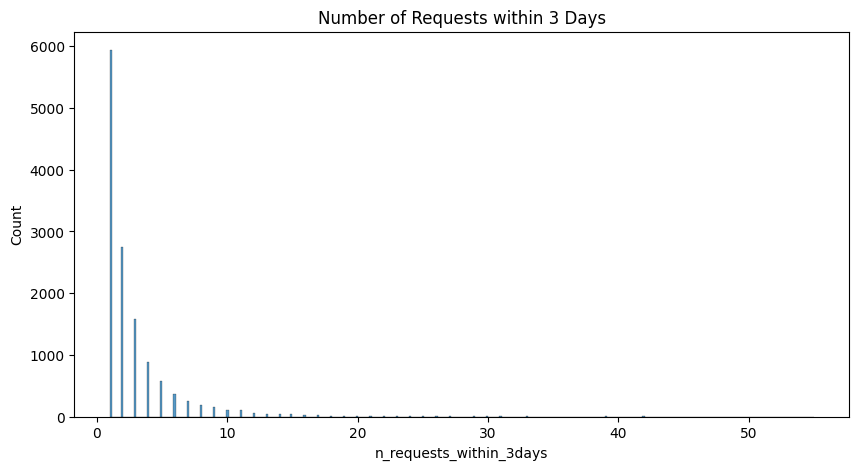

In [39]:
# Plot histogram of number of requests within 3 days
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='n_requests_within_3days')
plt.title(label='Number of Requests within 3 Days')
plt.show()

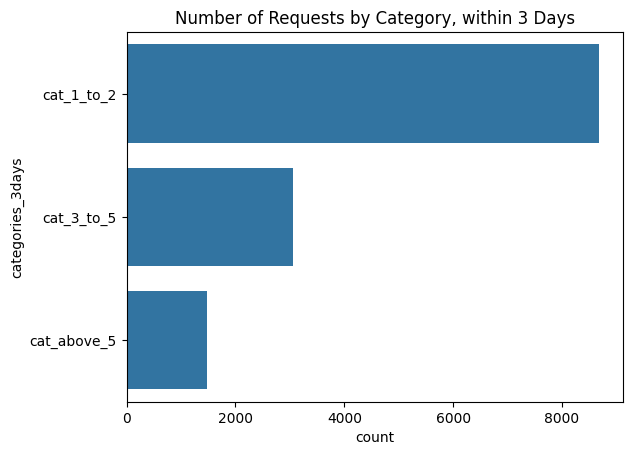

In [40]:
# Plot count plot of categories of requests within 3 days
sns.countplot(y=df['categories_3days'])
plt.title(label='Number of Requests by Category, within 3 Days')
plt.show()

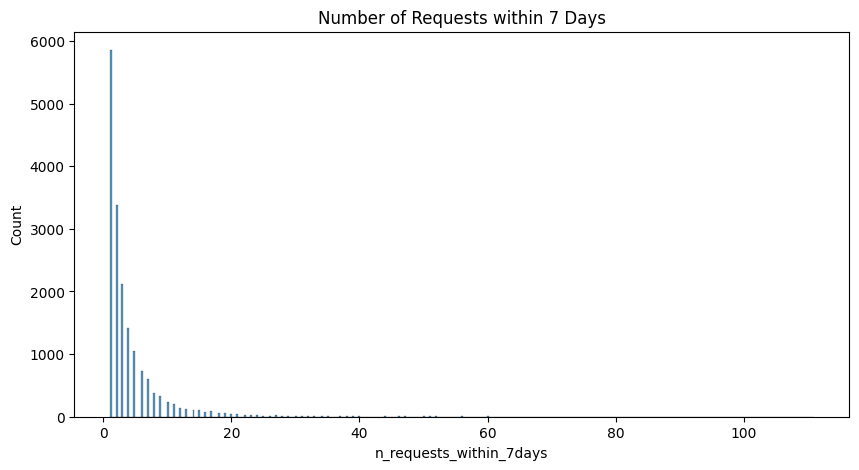

In [41]:
# Plot histogram of number of requests within 7 days
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='n_requests_within_7days')
plt.title(label='Number of Requests within 7 Days')
plt.show()

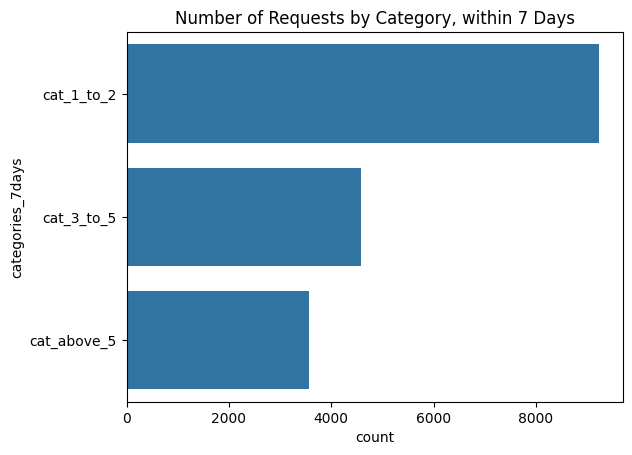

In [42]:
# Plot count plot of categories of requests within 7 days
sns.countplot(y=df['categories_7days'])
plt.title(label='Number of Requests by Category, within 7 Days')
plt.show()

In [43]:
# Get categorical columns
df_cat = df.select_dtypes(include='object')

# Get numerical columns
df_num = df.select_dtypes(exclude='object')

In [44]:
# Check categorical columns
list(df_cat.columns)

['type', 'furnishing', 'lease_type', 'parking', 'building_type']

In [45]:
# Check numerical columns
list(df_num.columns)

['bathroom',
 'floor',
 'total_floor',
 'gym',
 'lift',
 'property_age',
 'property_size',
 'swimming_pool',
 'rent',
 'deposit',
 'photo_count',
 'n_requests_within_7days',
 'categories_7days',
 'n_requests_within_3days',
 'categories_3days']

In [46]:
# Sample of categorical data
df_cat.sample(n=5)

,type,furnishing,lease_type,parking,building_type
13075,BHK2,FULLY_FURNISHED,FAMILY,FOUR_WHEELER,AP
8885,BHK2,SEMI_FURNISHED,FAMILY,BOTH,AP
2490,BHK3,SEMI_FURNISHED,FAMILY,BOTH,AP
7870,BHK2,SEMI_FURNISHED,ANYONE,TWO_WHEELER,IF
2734,BHK2,SEMI_FURNISHED,ANYONE,BOTH,AP


In [47]:
# Sample of numerical data
df_num.sample(n=5)

,bathroom,floor,total_floor,gym,lift,property_age,property_size,swimming_pool,rent,deposit,photo_count,n_requests_within_7days,categories_7days,n_requests_within_3days,categories_3days
7481,1,3,3.0,0,0,8,150,0,4000,25000,4,3,cat_3_to_5,NaN,NaN
2452,1,0,3.0,0,0,2,850,0,7000,50000,0,7,cat_above_5,4.0,cat_3_to_5
3266,1,0,1.0,0,0,0,800,0,7500,60000,8,14,cat_above_5,9.0,cat_above_5
5707,1,2,3.0,0,0,5,700,0,6800,50000,7,1,cat_1_to_2,1.0,cat_1_to_2
2693,2,1,3.0,0,1,3,1100,0,21000,210000,0,1,cat_1_to_2,1.0,cat_1_to_2


In [48]:
# Show count of distinct values for all categorical columns
for col in df_cat.columns:
    print(f'Column name: {col}\n{df_cat[col].value_counts()}\n{"-" * 60}\n')

Column name: type
type
BHK2        8510
BHK1        4508
BHK3        2691
RK1         1497
BHK4         157
BHK4PLUS      23
Name: count, dtype: int64
------------------------------------------------------------

Column name: furnishing
furnishing
SEMI_FURNISHED     13523
NOT_FURNISHED       2917
FULLY_FURNISHED      946
Name: count, dtype: int64
------------------------------------------------------------

Column name: lease_type
lease_type
FAMILY      8401
ANYONE      8026
BACHELOR     928
COMPANY       31
Name: count, dtype: int64
------------------------------------------------------------

Column name: parking
parking
TWO_WHEELER     8059
BOTH            7771
NONE             921
FOUR_WHEELER     635
Name: count, dtype: int64
------------------------------------------------------------

Column name: building_type
building_type
IF    10171
AP     6000
IH     1177
Name: count, dtype: int64
------------------------------------------------------------



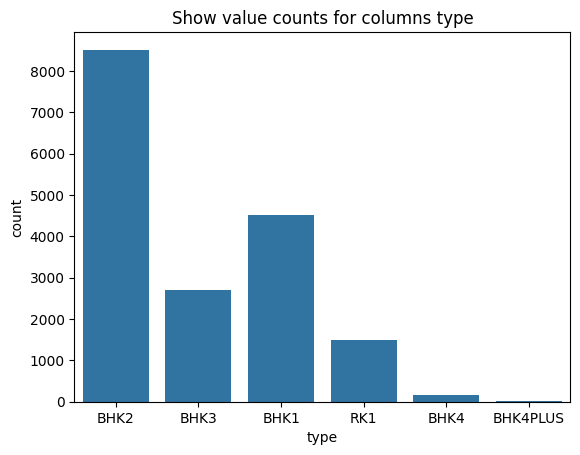

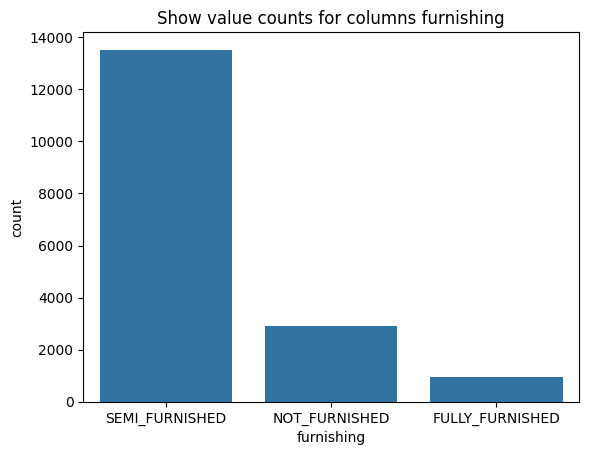

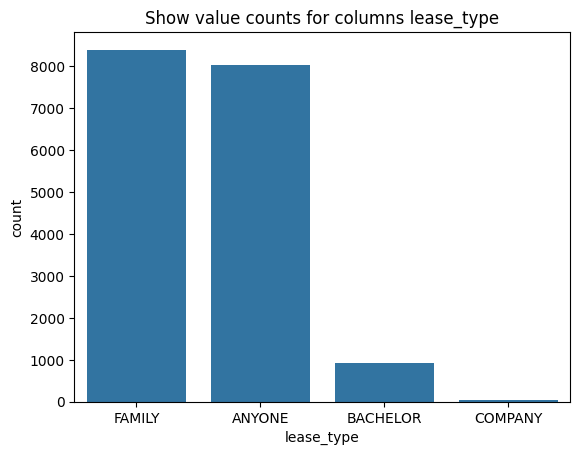

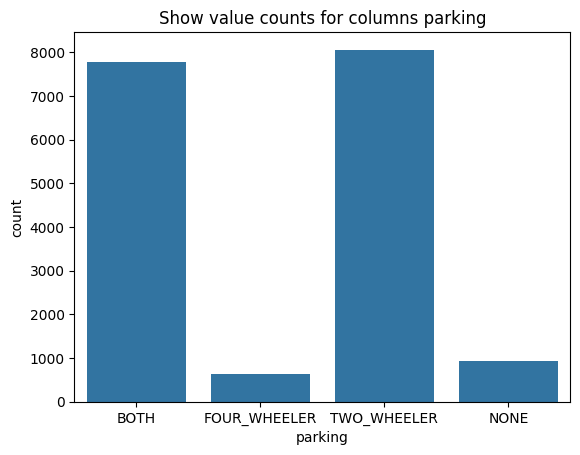

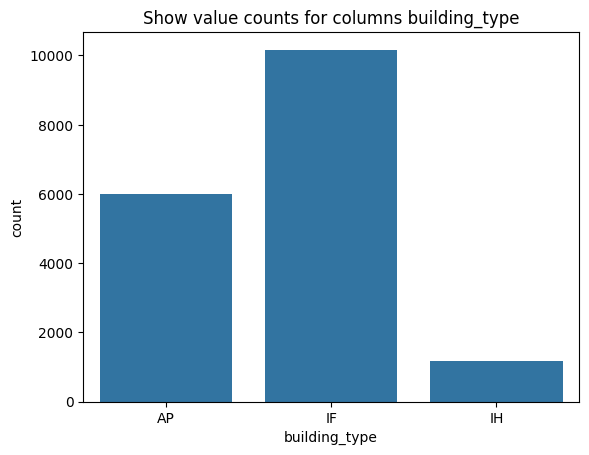

In [49]:
# Plot count of distinct values for all categorical columns
for col in df_cat.columns:
    sns.countplot(data=df, x=col)
    plt.title(label=f'Show value counts for columns {col}')
    plt.show()

In [50]:
# Show first 5 rows of numerical columns DataFrame
df_num.head()

,bathroom,floor,total_floor,gym,lift,property_age,property_size,swimming_pool,rent,deposit,photo_count,n_requests_within_7days,categories_7days,n_requests_within_3days,categories_3days
0,1,3,4.0,1,1,2,850,1,12000,120000,7,4,cat_3_to_5,4.0,cat_3_to_5
1,2,4,11.0,1,1,1,1233,1,20000,150000,0,5,cat_3_to_5,3.0,cat_3_to_5
2,2,0,4.0,1,1,0,1200,0,15000,75000,12,22,cat_above_5,15.0,cat_above_5
3,2,3,4.0,0,0,1,1300,0,17000,150000,9,7,cat_above_5,5.0,cat_3_to_5
4,1,1,2.0,0,0,4,450,0,6500,40000,7,52,cat_above_5,25.0,cat_above_5


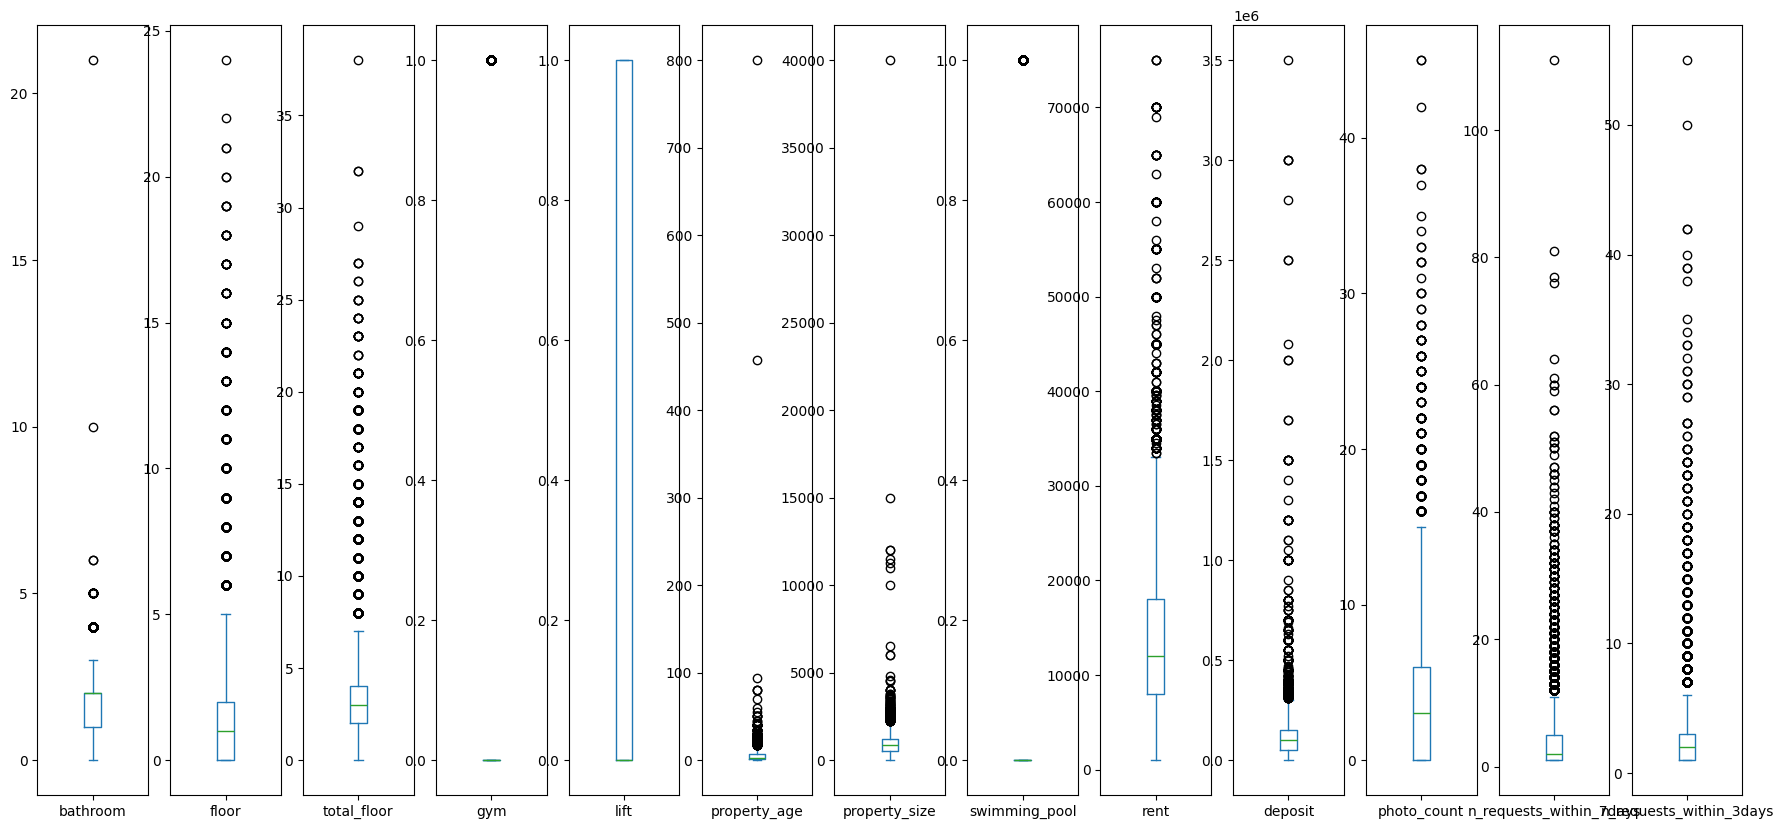

In [51]:
# Plot box plots to show ranges of values and outliers
df_num.plot(kind='box', subplots=True, sharex=False, sharey=False, figsize=(22, 10))
plt.show()

In [52]:
# Summary statistics for numerical columns
df_num.describe()

,bathroom,floor,total_floor,gym,lift,property_age,property_size,swimming_pool,rent,deposit,photo_count,n_requests_within_7days,n_requests_within_3days
count,17386.000000,17386.000000,17363.000000,17386.000000,17386.000000,17386.000000,17386.000000,17386.000000,17386.000000,1.738600e+04,17386.000000,17386.000000,13210.000000
mean,1.702692,1.726101,3.382077,0.150063,0.265156,4.789141,912.091510,0.126769,13822.809847,1.145386e+05,3.803635,4.013632,2.802801
std,0.716630,2.041864,3.040158,0.357144,0.441429,8.781275,608.803608,0.332723,8272.442456,1.167101e+05,4.231098,5.050688,3.187711
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1000.000000,0.000000e+00,0.000000,1.000000,1.000000
25%,1.000000,0.000000,2.000000,0.000000,0.000000,1.000000,507.000000,0.000000,8000.000000,5.000000e+04,0.000000,1.000000,1.000000
50%,2.000000,1.000000,3.000000,0.000000,0.000000,3.000000,875.000000,0.000000,12000.000000,1.000000e+05,3.000000,2.000000,2.000000
75%,2.000000,2.000000,4.000000,0.000000,1.000000,7.000000,1200.000000,0.000000,18000.000000,1.500000e+05,6.000000,5.000000,3.000000
max,21.000000,24.000000,38.000000,1.000000,1.000000,800.000000,40000.000000,1.000000,75000.000000,3.500000e+06,45.000000,111.000000,55.000000


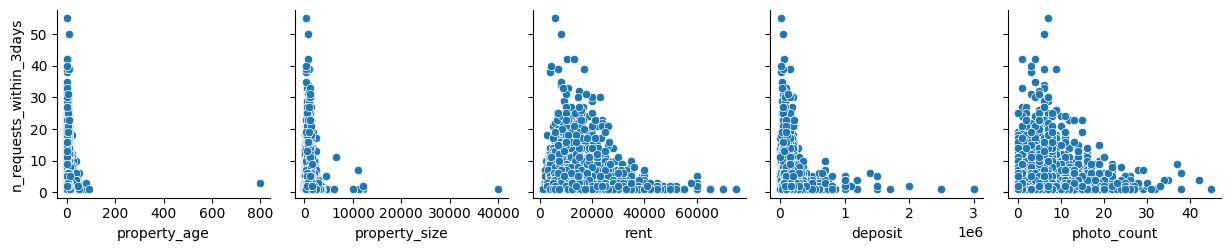

In [53]:
# Plot pairwise relationships between numerical columns and number of requests within 3 days
sns.pairplot(data=df, x_vars=['property_age', 'property_size', 'rent', 'deposit', 'photo_count'], y_vars=['n_requests_within_3days'])
plt.show()

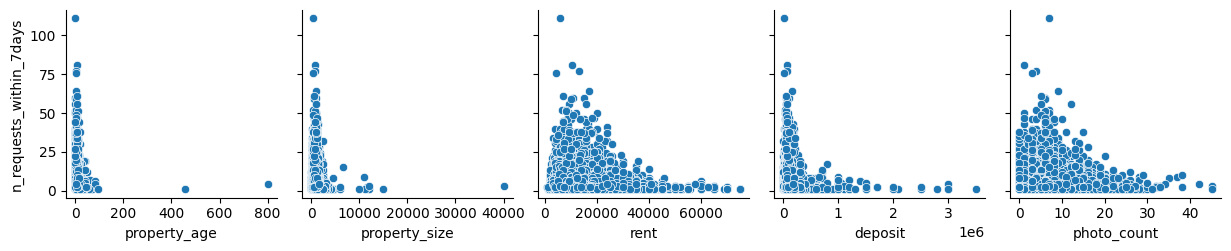

In [54]:
# Plot pairwise relationships between numerical columns and number of requests within 7 days
sns.pairplot(data=df, x_vars=['property_age', 'property_size', 'rent', 'deposit', 'photo_count'], y_vars=['n_requests_within_7days'])
plt.show()

## Feature Engineering <a id='feature-engineering'></a>

### Remove Outliers <a id='remove-outliers'></a>

In [55]:
# Define function remove outliers using quantiles
def remove_outlier(df_in, col_name, factor):
    """
    Remove outliers based on quantiles and adjustable factor
    """
    q1 = df_in[col_name].quantile(q=0.25)
    q3 = df_in[col_name].quantile(q=0.75)
    iqr = q3 - q1
    lower_bound = q1 - factor * iqr
    upper_bound = q3 + factor * iqr
    df_out = df_in.loc[(df_in[col_name] <= upper_bound) & (df_in[col_name] >= lower_bound)]
    return df_out

In [56]:
df_num.columns

Index(['bathroom', 'floor', 'total_floor', 'gym', 'lift', 'property_age',
       'property_size', 'swimming_pool', 'rent', 'deposit', 'photo_count',
       'n_requests_within_7days', 'categories_7days',
       'n_requests_within_3days', 'categories_3days'],
      dtype='object')

In [57]:
for col in df_num.columns:
    if col in ['gym', 'lift', 'swimming_pool', 'n_requests_within_3days', 'n_requests_within_7days']:
         df = remove_outlier(df, col, factor=2)

In [58]:
# Define functions for capping
def capping_for_3days(x):
    num = 10
    if x > num:
        return num
    else :
        return x
def capping_for_7days(x):
    num = 20
    if x > num:
        return num
    else :
        return x

In [59]:
# Trim values at input thresholds
df['n_requests_within_3days_capped'] = df['n_requests_within_3days'].apply(capping_for_3days)
df['n_requests_within_7days_capped'] = df['n_requests_within_7days'].apply(capping_for_7days)

In [60]:
df['n_requests_within_3days_capped'].value_counts()

n_requests_within_3days_capped
1.0    4268
2.0    1989
3.0    1150
4.0     651
5.0     416
6.0     233
7.0     130
Name: count, dtype: int64

In [61]:
df['n_requests_within_7days_capped'].value_counts()

n_requests_within_7days_capped
1     2179
2     1805
3     1331
4      961
5      731
      ... 
9      200
10     149
11     126
12      73
13      57
Name: count, Length: 13, dtype: int64

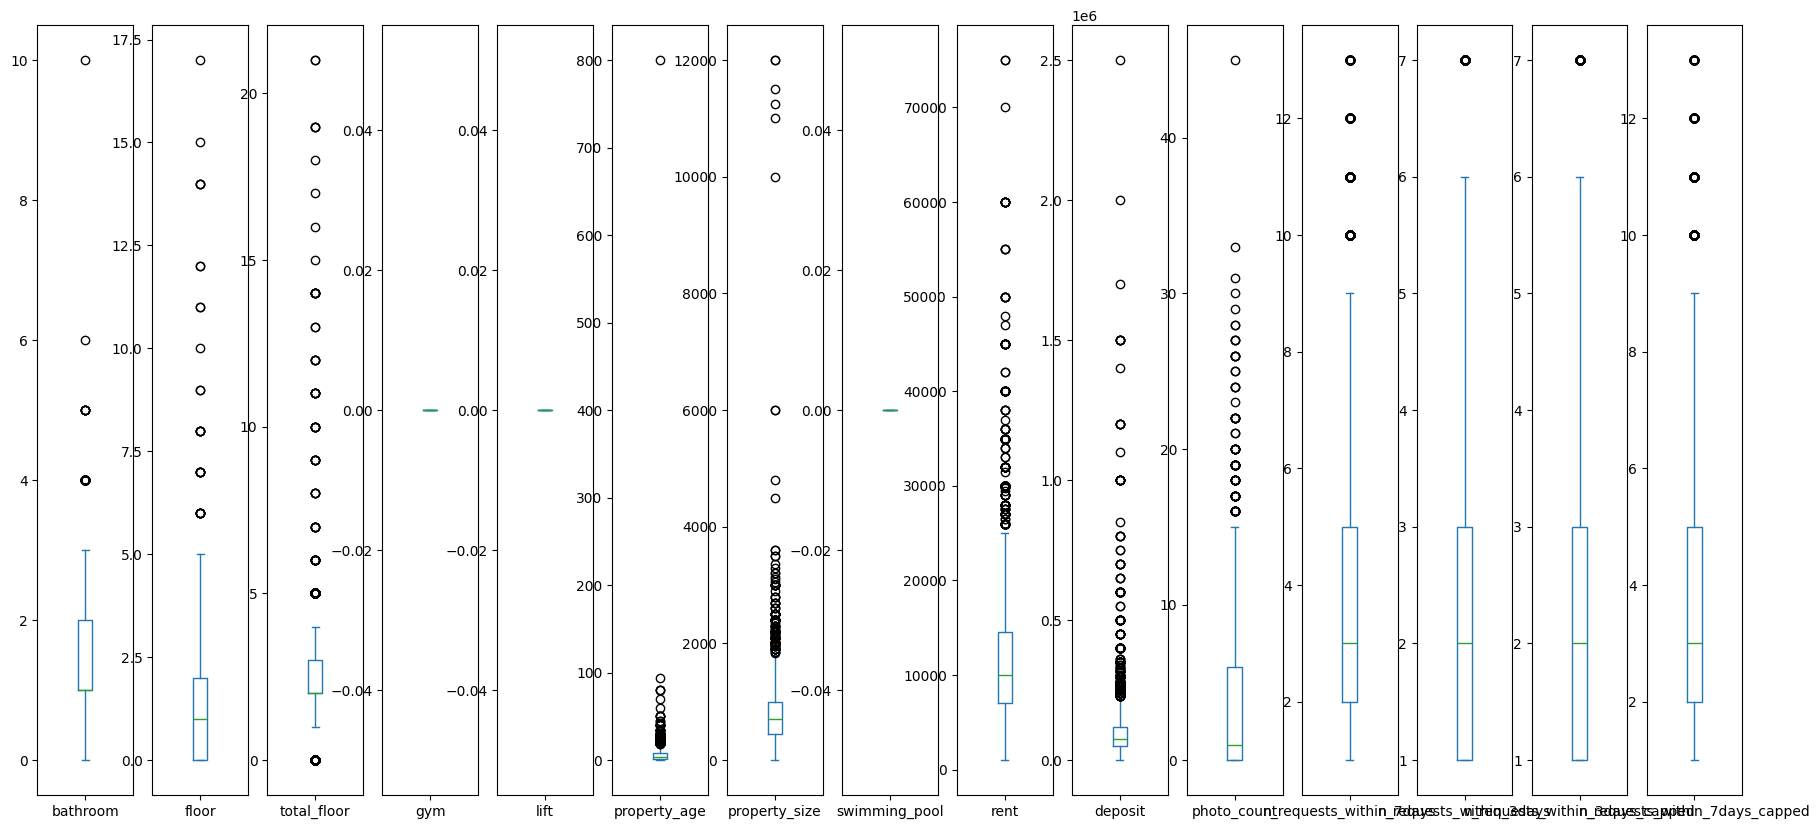

In [62]:
# Box plot after removing outliers and capping
df.plot(kind='box', subplots=True, sharex=False, sharey=False, figsize=(22, 10))
plt.show()

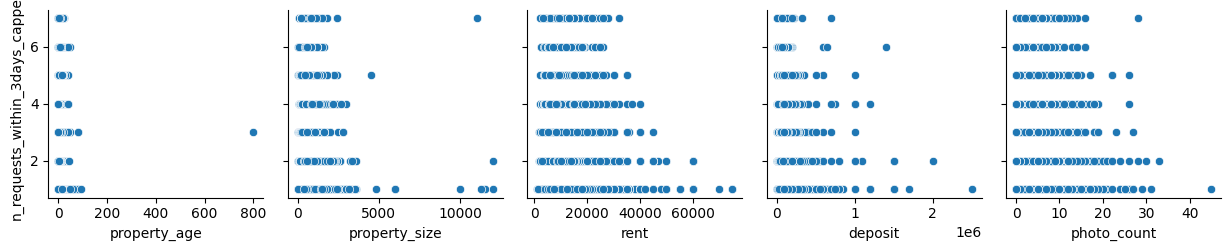

In [63]:
# Plot pair plots for numerical columns and number of requests within 3 days, capped
sns.pairplot(data=df, x_vars=['property_age', 'property_size', 'rent', 'deposit', 'photo_count'], y_vars=['n_requests_within_3days_capped'])
plt.show()

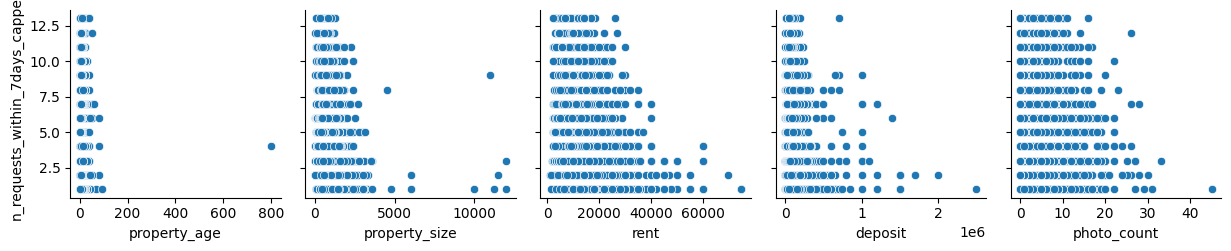

In [64]:
# Plot pair plots for numerical columns and number of requests within 7 days, capped
sns.pairplot(data=df, x_vars=['property_age', 'property_size', 'rent', 'deposit', 'photo_count'], y_vars=['n_requests_within_7days_capped'])
plt.show()

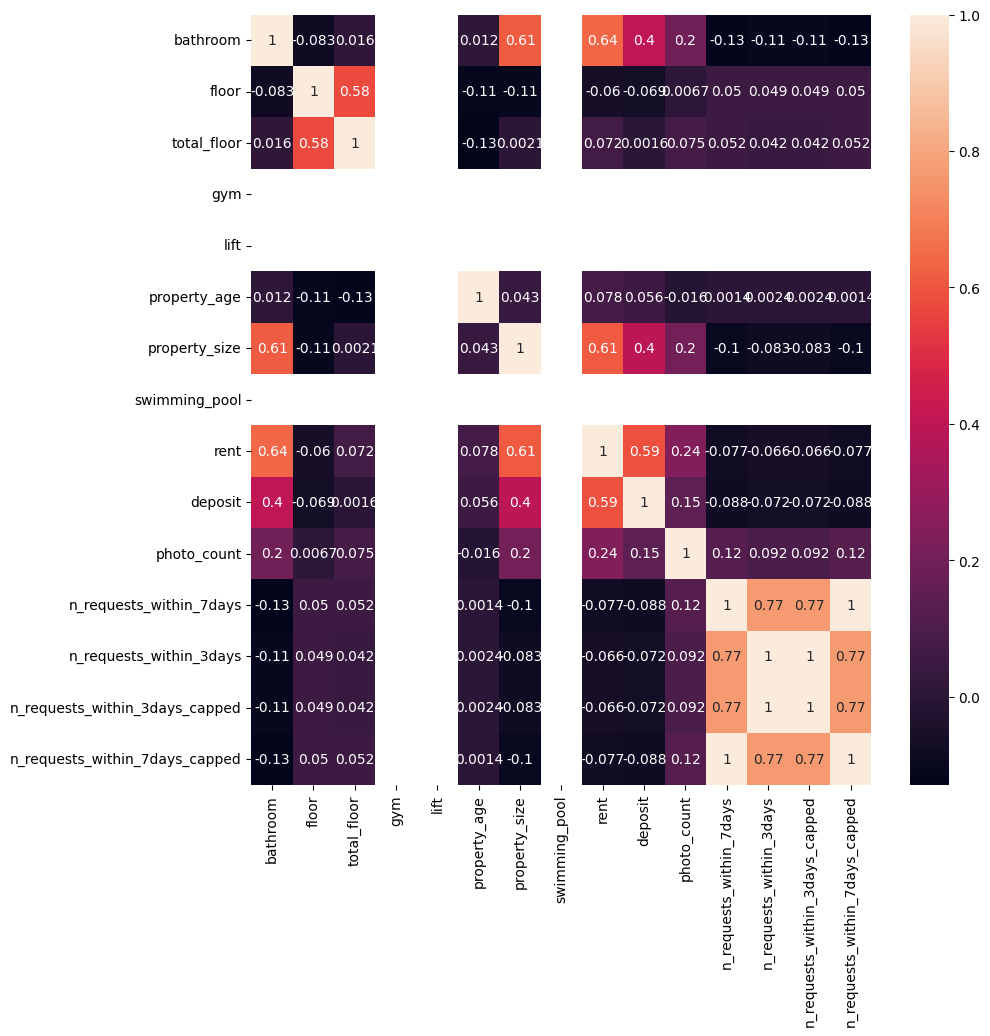

In [65]:
# Show correlation on heat map
plt.subplots(figsize=(10, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True)
plt.show()

### One Hot Encoding <a id='one-hot-encoding'></a>

In [66]:
df.sample(n=5)

,type,bathroom,floor,total_floor,furnishing,gym,lease_type,lift,parking,property_age,property_size,swimming_pool,rent,deposit,building_type,photo_count,n_requests_within_7days,categories_7days,n_requests_within_3days,categories_3days,n_requests_within_3days_capped,n_requests_within_7days_capped
2551,BHK3,2,1,1.0,SEMI_FURNISHED,0,FAMILY,0,TWO_WHEELER,9,1200,0,15000,150000,IF,9,1,cat_1_to_2,1.0,cat_1_to_2,1.0,1
14336,BHK2,2,0,1.0,SEMI_FURNISHED,0,ANYONE,0,TWO_WHEELER,8,750,0,9000,90000,IF,0,1,cat_1_to_2,1.0,cat_1_to_2,1.0,1
4246,BHK2,2,0,2.0,SEMI_FURNISHED,0,FAMILY,0,NONE,20,750,0,15000,100000,IF,9,2,cat_1_to_2,1.0,cat_1_to_2,1.0,2
3359,BHK1,1,1,2.0,SEMI_FURNISHED,0,FAMILY,0,BOTH,10,600,0,11000,110000,IF,12,2,cat_1_to_2,2.0,cat_1_to_2,2.0,2
5134,BHK2,2,0,1.0,SEMI_FURNISHED,0,BACHELOR,0,BOTH,23,975,0,25000,150000,IF,7,2,cat_1_to_2,1.0,cat_1_to_2,1.0,2


In [67]:
df.columns

Index(['type', 'bathroom', 'floor', 'total_floor', 'furnishing', 'gym',
       'lease_type', 'lift', 'parking', 'property_age', 'property_size',
       'swimming_pool', 'rent', 'deposit', 'building_type', 'photo_count',
       'n_requests_within_7days', 'categories_7days',
       'n_requests_within_3days', 'categories_3days',
       'n_requests_within_3days_capped', 'n_requests_within_7days_capped'],
      dtype='object')

In [68]:
# One Hot Encoder for categorical columns
# Divide data into categorical, numerical, and label
X = df.drop(columns=['n_requests_within_7days', 'categories_7days', 'n_requests_within_3days', 'categories_3days', 'n_requests_within_3days_capped', 'n_requests_within_7days_capped'])

x_cat_with_null = df[X.select_dtypes(include=['object']).columns]
x_remain_with_null = df[X.select_dtypes(exclude=['object']).columns]

y = df[['n_requests_within_7days', 'categories_7days', 'n_requests_within_3days', 'categories_3days', 'n_requests_within_3days_capped', 'n_requests_within_7days_capped']]

In [69]:
# Create DataFrames
x_remain = pd.DataFrame()
x_cat = pd.DataFrame()

In [70]:
# Fill null values in numeric columns with mean
for col in x_remain_with_null.columns:
    x_remain[col] = x_remain_with_null[col].fillna(value=x_remain_with_null[col].mean())

# Fill null values in categorical columns with mode
for col in x_cat_with_null.columns:
    x_cat[col] = x_cat_with_null[col].fillna(value=x_cat_with_null[col].mode()[0])

In [71]:
# Check missing values
x_remain.isna().sum()

bathroom         0
floor            0
total_floor      0
gym              0
lift             0
                ..
property_size    0
swimming_pool    0
rent             0
deposit          0
photo_count      0
Length: 11, dtype: int64

In [72]:
# One Hot Encoding
ohe = OneHotEncoder(categories='auto', handle_unknown='ignore')
feature_train = ohe.fit_transform(x_cat).toarray()

# Use list comprehension
feature_labels = [f'{i}_{label}' for i, labels in zip(x_cat.columns, ohe.categories_) for label in labels]
df_features = pd.DataFrame(data=feature_train, columns=feature_labels)

In [73]:
df_features.shape

(8837, 20)

In [74]:
df_features.sample(n=5)

,type_BHK1,type_BHK2,type_BHK3,type_BHK4,type_BHK4PLUS,type_RK1,furnishing_FULLY_FURNISHED,furnishing_NOT_FURNISHED,furnishing_SEMI_FURNISHED,lease_type_ANYONE,lease_type_BACHELOR,lease_type_COMPANY,lease_type_FAMILY,parking_BOTH,parking_FOUR_WHEELER,parking_NONE,parking_TWO_WHEELER,building_type_AP,building_type_IF,building_type_IH
6471,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6582,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
8240,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3879,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
7444,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


### MinMax Scaler <a id='minmax-scaler'></a>

In [75]:
# Scale data
scaler = MinMaxScaler()
x_remain_scaled = scaler.fit_transform(x_remain)
x_remain_scaled = pd.DataFrame(data=x_remain_scaled, columns=x_remain.columns)

In [76]:
y.head()

,n_requests_within_7days,categories_7days,n_requests_within_3days,categories_3days,n_requests_within_3days_capped,n_requests_within_7days_capped
3,7,cat_above_5,5.0,cat_3_to_5,5.0,7
10,13,cat_above_5,7.0,cat_above_5,7.0,13
18,8,cat_above_5,6.0,cat_above_5,6.0,8
19,5,cat_3_to_5,4.0,cat_3_to_5,4.0,5
20,4,cat_3_to_5,1.0,cat_1_to_2,1.0,4


In [77]:
# Concatenate data for requests within 3 days
data_with_3days = pd.concat(objs=[df_features.reset_index(drop=True), x_remain_scaled.reset_index(drop=True), y[['n_requests_within_3days', 'n_requests_within_3days_capped', 'categories_3days']].reset_index(drop=True)], axis=1)

In [78]:
# Drop rows with missing values
data_with_3days.dropna(inplace=True)
data_with_3days.shape

(8837, 34)

In [79]:
# Concatenate data for requests within 7 days
data_with_7days = pd.concat(objs=[df_features.reset_index(drop=True), x_remain_scaled.reset_index(drop=True), y[['n_requests_within_7days', 'n_requests_within_7days_capped', 'categories_7days']].reset_index(drop=True)], axis=1)

In [80]:
# Drop rows with missing values
data_with_7days.dropna(inplace=True)
data_with_7days.shape

(8837, 34)

## Machine Learning <a id='machine-learning'></a>

### Predicting Interactions within 3 Days <a id='predict-three-days'></a>

In [81]:
# Sample of data with 3 days
data_with_3days.sample()

,type_BHK1,type_BHK2,type_BHK3,type_BHK4,type_BHK4PLUS,type_RK1,furnishing_FULLY_FURNISHED,furnishing_NOT_FURNISHED,furnishing_SEMI_FURNISHED,lease_type_ANYONE,lease_type_BACHELOR,lease_type_COMPANY,lease_type_FAMILY,parking_BOTH,parking_FOUR_WHEELER,parking_NONE,parking_TWO_WHEELER,building_type_AP,building_type_IF,building_type_IH,bathroom,floor,total_floor,gym,lift,property_age,property_size,swimming_pool,rent,deposit,photo_count,n_requests_within_3days,n_requests_within_3days_capped,categories_3days
7970,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.1,0.058824,0.095238,0.0,0.0,0.0075,0.0375,0.0,0.081081,0.02,0.0,3.0,3.0,cat_3_to_5


In [82]:
# Get data
X = data_with_3days.drop(columns=['n_requests_within_3days', 'n_requests_within_3days_capped', 'categories_3days'])
y = data_with_3days[['n_requests_within_3days', 'n_requests_within_3days_capped', 'categories_3days']]

#### First Iteration

In [83]:
# Set seed for reproducibility
seed = 42

# Split data into training and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y['n_requests_within_3days'], test_size=0.2, random_state=seed)

In [84]:
# Store models in list
models = [
    ('Linear Regression', LinearRegression()),
    ('Lasso', Lasso(random_state=seed)),
    ('K-Nearest Neighbors Regression', KNeighborsRegressor()),
    ('Decision Tree Regression', DecisionTreeRegressor(random_state=seed)),
    ('XGBoost Regression', XGBRegressor(random_state=seed))
]

In [85]:
# Define function for training and evaluating models
def train_and_evaluate_model(name, model, X_train, y_train, X_test, y_test):
    """
    Train and evaluate models
    """
    # Initiate model
    regressor = model
    
    # Fit model to training data
    regressor.fit(X_train, y_train)
    
    # Make predictions on test data
    y_pred = regressor.predict(X_test)
    
    # Calculate error metric
    rms = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Results message
    msg = '%s: RMS => (%f)' % (name, rms)
    
    return msg

In [86]:
# Get results
results = [train_and_evaluate_model(name, model, X_train, y_train, X_test, y_test) for name, model in models]

for result in results:
    print(result)

Linear Regression: RMS => (1.478684)
Lasso: RMS => (1.504865)
K-Nearest Neighbors Regression: RMS => (1.610479)
Decision Tree Regression: RMS => (2.047478)
XGBoost Regression: RMS => (1.549951)


The linear regression model is the best solution because it has the lowest root mean squared (RMS) error.

#### Second Iteration with capped target column

In [87]:
# Split data into training and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y['n_requests_within_3days_capped'], test_size=0.2, random_state=seed)

In [88]:
# Get results
results = [train_and_evaluate_model(name, model, X_train, y_train, X_test, y_test) for name, model in models]

for result in results:
    print(result)

Linear Regression: RMS => (1.478684)
Lasso: RMS => (1.504865)
K-Nearest Neighbors Regression: RMS => (1.610479)
Decision Tree Regression: RMS => (2.047478)
XGBoost Regression: RMS => (1.549951)


#### Third Iteration with classification

In [89]:
# Split data into training and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y['categories_3days'], test_size=0.2, random_state=seed)

In [90]:
y['categories_3days'].value_counts()

categories_3days
cat_1_to_2     6257
cat_3_to_5     2217
cat_above_5     363
Name: count, dtype: int64

In [91]:
# Logistic Regression

# Initiate model
lr = LogisticRegression(solver='newton-cg')

# Fit model to training data
lr.fit(X_train, y_train)

# Predict probabilities for all classes on test data
y_pred_lr_pro = lr.predict_proba(X_test)

# Make predictions on test data
y_pred_lr = lr.predict(X_test)

# Results
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

  cat_1_to_2       0.69      1.00      0.81      1211
  cat_3_to_5       0.25      0.00      0.00       476
 cat_above_5       0.00      0.00      0.00        81

    accuracy                           0.68      1768
   macro avg       0.31      0.33      0.27      1768
weighted avg       0.54      0.68      0.56      1768



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

The F1 score is 68% overall, with the `cat_1_to_2` category showing a higher score compared to the other categories. This data is unbalanced.

In [92]:
# Random Forest

# Initiate model
rfc = RandomForestClassifier(n_estimators=10, class_weight='balanced', random_state=seed)

# Fit model to training data
rfc.fit(X_train, y_train)

# Predict probabilities for all classes on test data
y_pred_rfc_pro = rfc.predict_proba(X_test)

# Make predictions on test data
y_pred_rfc = rfc.predict(X_test)

# Results
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

  cat_1_to_2       0.70      0.92      0.79      1211
  cat_3_to_5       0.37      0.13      0.19       476
 cat_above_5       0.00      0.00      0.00        81

    accuracy                           0.67      1768
   macro avg       0.35      0.35      0.33      1768
weighted avg       0.58      0.67      0.59      1768



The F1 score is 67% overall, similar to logistic regression.

### Predicting Interactions within 7 Days <a id='predict-seven-days'></a>

In [93]:
# Sample of data with 7 days
data_with_7days.sample()

,type_BHK1,type_BHK2,type_BHK3,type_BHK4,type_BHK4PLUS,type_RK1,furnishing_FULLY_FURNISHED,furnishing_NOT_FURNISHED,furnishing_SEMI_FURNISHED,lease_type_ANYONE,lease_type_BACHELOR,lease_type_COMPANY,lease_type_FAMILY,parking_BOTH,parking_FOUR_WHEELER,parking_NONE,parking_TWO_WHEELER,building_type_AP,building_type_IF,building_type_IH,bathroom,floor,total_floor,gym,lift,property_age,property_size,swimming_pool,rent,deposit,photo_count,n_requests_within_7days,n_requests_within_7days_capped,categories_7days
3429,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.1,0.176471,0.142857,0.0,0.0,0.005,0.0425,0.0,0.121622,0.02,0.133333,2,2,cat_1_to_2


In [94]:
# Get data
X = data_with_7days.drop(columns=['n_requests_within_7days', 'n_requests_within_7days_capped', 'categories_7days'])
y = data_with_7days[['n_requests_within_7days', 'n_requests_within_7days_capped', 'categories_7days']]

#### First Iteration

In [95]:
# Split data into training and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y['n_requests_within_7days'], test_size=0.2, random_state=seed)

In [96]:
# Get results
results = [train_and_evaluate_model(name, model, X_train, y_train, X_test, y_test) for name, model in models]

for result in results:
    print(result)

Linear Regression: RMS => (2.572375)
Lasso: RMS => (2.649392)
K-Nearest Neighbors Regression: RMS => (2.835860)
Decision Tree Regression: RMS => (3.663173)
XGBoost Regression: RMS => (2.689849)


The linear regression model is the best solution because it has the lowest root mean square (RMS) error.

#### Second Iteration with capped target column

In [97]:
# Split data into training and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y['n_requests_within_7days_capped'], test_size=0.2, random_state=seed)

In [98]:
# Get results
results = [train_and_evaluate_model(name, model, X_train, y_train, X_test, y_test) for name, model in models]

for result in results:
    print(result)

Linear Regression: RMS => (2.572375)
Lasso: RMS => (2.649392)
K-Nearest Neighbors Regression: RMS => (2.835860)
Decision Tree Regression: RMS => (3.663173)
XGBoost Regression: RMS => (2.689849)


#### Third Iteration with classification

In [99]:
# Split data into training and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y['categories_7days'], test_size=0.2, random_state=seed)

In [100]:
y['categories_7days'].value_counts()

categories_7days
cat_1_to_2     3984
cat_3_to_5     3023
cat_above_5    1830
Name: count, dtype: int64

In [101]:
# Logistic Regression

# Initiate model
lr = LogisticRegression(solver='newton-cg')

# Fit model to training data
lr.fit(X_train, y_train)

# Predict probabilities for all classes on test data
y_pred_lr_pro = lr.predict_proba(X_test)

# Make predictions on test data
y_pred_lr = lr.predict(X_test)

# Results
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

  cat_1_to_2       0.49      0.83      0.61       798
  cat_3_to_5       0.33      0.17      0.23       593
 cat_above_5       0.37      0.08      0.14       377

    accuracy                           0.45      1768
   macro avg       0.39      0.36      0.33      1768
weighted avg       0.41      0.45      0.38      1768



In [102]:
# Random Forest

# Initiate model
rfc = RandomForestClassifier(n_estimators=10, class_weight='balanced', random_state=seed)

# Fit model to training data
rfc.fit(X_train, y_train)

# Predict probabilities for all classes on test data
y_pred_rfc_pro = rfc.predict_proba(X_test)

# Make predictions on test data
y_pred_rfc = rfc.predict(X_test)

# Results
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

  cat_1_to_2       0.50      0.63      0.56       798
  cat_3_to_5       0.35      0.32      0.34       593
 cat_above_5       0.33      0.19      0.24       377

    accuracy                           0.43      1768
   macro avg       0.40      0.38      0.38      1768
weighted avg       0.42      0.43      0.42      1768



The F1 scores with logistic regression and random forest are low so these models are not the best solutions.

## Deep Learning <a id='deep-learning'></a>

In [103]:
# Get data
X = data_with_3days.drop(columns=['n_requests_within_3days', 'n_requests_within_3days_capped', 'categories_3days'])
y = data_with_3days[['n_requests_within_3days', 'n_requests_within_3days_capped', 'categories_3days']]

In [104]:
# Set seed for reproducibility
seed = 42

# Split data into training and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y['n_requests_within_3days'], test_size=0.2, random_state=seed)

In [105]:
# Initiate model
model = Sequential([
    Dense(units=512, activation='relu', input_shape=(X_train.shape[1], )),
    Dense(units=512, activation='relu'),
    Dense(units=1, activation='linear')
])

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit model
history = model.fit(X_train, y_train, epochs=50)

2023-12-05 08:18:04.343796: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2023-12-05 08:18:04.343821: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-12-05 08:18:04.343841: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-12-05 08:18:04.343886: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-05 08:18:04.343907: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50
 15/221 [=>............................] - ETA: 0s - loss: 3.3137 

2023-12-05 08:18:04.794127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


221/221 [==============================] - 1s 4ms/step - loss: 2.1241
Epoch 2/50
221/221 [==============================] - 1s 3ms/step - loss: 2.0199
Epoch 3/50
221/221 [==============================] - 1s 3ms/step - loss: 2.0345
Epoch 4/50
221/221 [==============================] - 1s 3ms/step - loss: 2.0341
Epoch 5/50
221/221 [==============================] - 1s 3ms/step - loss: 2.0908
Epoch 6/50
221/221 [==============================] - 1s 3ms/step - loss: 2.1346
Epoch 7/50
221/221 [==============================] - 1s 3ms/step - loss: 2.1441
Epoch 8/50
221/221 [==============================] - 1s 3ms/step - loss: 2.1881
Epoch 9/50
221/221 [==============================] - 1s 3ms/step - loss: 2.2036
Epoch 10/50
221/221 [==============================] - 1s 3ms/step - loss: 2.2279
Epoch 11/50
221/221 [==============================] - 1s 3ms/step - loss: 2.3522
Epoch 12/50
221/221 [==============================] - 1s 3ms/step - loss: 2.2580
Epoch 13/50
221/221 [===============

The deep learning model has a higher loss than the linear regression model.

The best solution is the linear regression model because it has the lowest root mean squared (RMS) error.

This notebook was inspired by the [Property Click Prediction](https://platform.stratascratch.com/data-projects/property-click-prediction) data project on [StrataScratch](https://www.stratascratch.com/).